## [1] Feature Engineering
- At this section, we conduct feature engineering, to generate features based on URL
- All original features from the dataset were removed due to the lack of documentation on how they were created. Without clear definitions, these original features could not guarantee reproducibility, reliability, or interpretability, which are essential for a transparent and trustworthy model.
- Although many phishing datasets include additional features such as HTML-based attributes or traffic statistics, we intentionally restrict our feature set to URL-only features. This design choice ensures that the detector can be applied directly to raw URLs in real-world scenarios, where HTML content, domain metadata, or server-side information may not be easily accessible.

#### Breakdown of an URL (example)
https://subdomain.example.com:8080/path/to/file.html?key1=value1&key2=value2#section
- Scheme / Protocol: https
- Host / Domain: subdomain.example.com
    - Subdomain: subdomain
    - Second-Level-Domain (SLD): example
    - Top-Level-Domain (TLD): com
- Port: 8080
- Path: path/to/file.html
    - Directory-Path: path/to
    - Filename: file.html
    - File-Extension: html
- Query: key1=value1&key2=value2
    - Params: key1=value1 and key2=value2
- Fragment/Anchor: section

In [1]:
# import packages for data processing
import pandas as pd
import numpy as np

# URL parsing
import re
from urllib.parse import urlparse
from collections import Counter
import tldextract
import ipaddress

# set display options
#pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

In [13]:
# load data
df = pd.read_csv('../dataset/train.csv')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9143 entries, 0 to 9142
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   url     9143 non-null   object
 1   target  9143 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 143.0+ KB


In [6]:
def preprocess(df):
    # fix mapping of status column
    status_mapping = {'legitimate': 0, 'phishing': 1}
    df['target'] = df['status'].map(status_mapping)
    
    # drop all cols other than 'url' and 'target'
    df = df[['url', 'target']]
    return df

In [16]:
df_processed = df

In [17]:
def decompose_single_url(url):
    parsed = urlparse(url)
    hostname = parsed.hostname or None
    ext = tldextract.extract(hostname) if hostname else None
    
    # path decomposition
    path_parts = [p for p in parsed.path.split('/') if p] if parsed.path else []
    filename = path_parts[-1] if path_parts else None
    file_extension = filename.split('.')[-1] if filename and '.' in filename else None
    directory_path = '/'.join(path_parts[:-1]) if len(path_parts) > 1 else None
    
    # query parameters
    query_params = parsed.query.split('&') if parsed.query else None
    
    return {
        'url': url,
        'protocol': parsed.scheme or None,
        'hostname': hostname,
        'port': parsed.port if parsed.port is not None else None,
        'path': parsed.path or None,
        'query': parsed.query or None,
        'fragment': parsed.fragment or None,
        'subdomains': ext.subdomain if ext else None,
        'sld': ext.domain if ext else None,
        'tld': ext.suffix if ext else None,
        'filename': filename,
        'file_extension': file_extension,
        'directory_path': directory_path,
        'query_params': query_params
    }

In [18]:
def decompose_url(df):
    df_decomposed = df['url'].apply(lambda x: pd.Series(decompose_single_url(x)))
    df_decomposed = pd.concat([df_decomposed, df['target']], axis=1)
    # convert all empty strings to None
    df_decomposed.replace('', None, inplace=True)
    # transform url
    def reconstruct_base_url(row):
        if not row['hostname']:
            return row['url']  # return original if parsing failed
        protocol = row['protocol'] if row['protocol'] else 'http'
        return f"{protocol}://{row['hostname']}"
    df_decomposed['url'] = df_decomposed.apply(reconstruct_base_url, axis=1)
    return df_decomposed

In [19]:
df_decomposed = decompose_url(df_processed)

In [20]:
df_decomposed.head()

,url,protocol,hostname,port,path,query,fragment,subdomains,sld,tld,filename,file_extension,directory_path,query_params,target
0,http://cafecitoperez.ivanidzakovic.com,http,cafecitoperez.ivanidzakovic.com,NaN,/admin/aociufd/goodl.vci/e6edcebab88867a2f99a3...,cmd=login_submit&amp;id=f7d4a85c3588b5be032bea...,None,cafecitoperez,ivanidzakovic,com,login.php,php,admin/aociufd/goodl.vci/e6edcebab88867a2f99a34...,"[cmd=login_submit, amp;id=f7d4a85c3588b5be032b...",1
1,https://www.guiadoexcel.com.br,https,www.guiadoexcel.com.br,NaN,/,None,None,www,guiadoexcel,com.br,None,None,None,None,0
2,https://www.mysummercamps.com,https,www.mysummercamps.com,NaN,/forum/For_Camp_Directors_C3/Research_and_Lear...,url=http://server.bludomain82.com/~bree2/review/,_&amp;?hannah.judge@discsystems.co.uk,www,mysummercamps,com,gforum.cgi,cgi,forum/For_Camp_Directors_C3/Research_and_Learn...,[url=http://server.bludomain82.com/~bree2/revi...,1
3,https://www.health-island.net,https,www.health-island.net,NaN,/,None,None,www,health-island,net,None,None,None,None,0
4,https://www.youtube.com,https,www.youtube.com,NaN,/watch,v=0jqwikTk9gw,None,www,youtube,com,watch,None,None,[v=0jqwikTk9gw],0


In [21]:
df_decomposed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9143 entries, 0 to 9142
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   url             9143 non-null   object 
 1   protocol        9143 non-null   object 
 2   hostname        9143 non-null   object 
 3   port            24 non-null     float64
 4   path            8628 non-null   object 
 5   query           1223 non-null   object 
 6   fragment        38 non-null     object 
 7   subdomains      7035 non-null   object 
 8   sld             9143 non-null   object 
 9   tld             9063 non-null   object 
 10  filename        6433 non-null   object 
 11  file_extension  2413 non-null   object 
 12  directory_path  4554 non-null   object 
 13  query_params    1223 non-null   object 
 14  target          9143 non-null   int64  
dtypes: float64(1), int64(1), object(13)
memory usage: 1.0+ MB


In [ ]:
def extract_url_features(df):

    final_df = df.copy()

    ## PROTOCOL FEATURES
    # final_df['is_https'] = (final_df['protocol'] == 'https').astype(int)
    final_df['is_http'] = (final_df['protocol'] == 'http').astype(int)

    ## DOMAIN FEATURES
    final_df['has_subdomain'] = final_df['subdomains'].notna().astype(int)
    final_df['has_tld'] = final_df['tld'].notna().astype(int)
    final_df['num_subdomain'] = final_df['subdomains'].apply(lambda x: len(x.split('.')) if x else 0)
    # check if is IP address
    def is_ip_address(hostname):
        try:
            ipaddress.ip_address(hostname)
            return 1  
        except:
            return 0
    final_df['is_domain_ip'] = final_df['hostname'].apply(is_ip_address)
    # suspicious punctuation in domain
    final_df['num_hyphens_domain'] = final_df['hostname'].str.count('-')
    final_df['num_dots_domain'] = final_df['hostname'].str.count(r'\.')
    # detect punycode
    final_df['is_punycode'] = final_df['hostname'].str.contains('xn--', regex=False, na=False).astype(int)
    
    ## PORT FEATURES
    # final_df['has_port'] = final_df['port'].notna().astype(int)

    ## PATH FEATURES
    final_df['has_path'] = final_df['path'].apply(lambda x: 1 if x and x != '/' else 0)
    final_df['path_depth'] = final_df['path'].apply(lambda x: len([p for p in x.split('/') if p]) if x else 0)
    final_df['has_directory_path'] = final_df['directory_path'].apply(lambda x: 1 if x and x != '/' else 0)

    ## FILE FEATURES
    final_df['has_filename'] = final_df['filename'].notna().astype(int)
    final_df['has_file_extension'] = final_df['file_extension'].notna().astype(int)

    ## QUERY FEATURES
    final_df['has_query'] = final_df['query'].notna().astype(int) 
    final_df['num_query_params'] = final_df['query_params'].apply(lambda x: len([p for p in x if p]) if x else 0)
    
    ## FRAGMENT FEATURES
    # final_df['has_fragment'] = final_df['fragment'].notna().astype(int)

    ## LENGTH FEATURES
    final_df['length_url'] = final_df['url'].str.len()
    final_df['length_hostname'] = final_df['hostname'].str.len()
    final_df['length_tld'] = final_df['tld'].str.len()
    final_df['length_sld'] = final_df['sld'].str.len()
    final_df['length_subdomains'] = final_df['subdomains'].str.len()
    final_df['length_path'] = final_df['path'].str.len()
    final_df['length_query'] = final_df['query'].str.len()
    # final_df['length_fragment'] = final_df['fragment'].str.len()

    ## PUNCTUATION FEATURES
    # final_df['num_dots'] = final_df['url'].str.count(r'\.')
    # final_df['num_hyphens'] = final_df['url'].str.count('-')
    # final_df['num_at'] = final_df['url'].str.count('@')
    # final_df['num_question_marks'] = final_df['url'].str.count(r'\?')
    # final_df['num_and'] = final_df['url'].str.count('&')
    # final_df['num_equal'] = final_df['url'].str.count('=')
    # final_df['num_underscores'] = final_df['url'].str.count('_')    
    # final_df['num_slashes'] = final_df['url'].str.count('/')
    # final_df['num_percent'] = final_df['url'].str.count('%')
    # final_df['num_dollars'] = final_df['url'].str.count(r'\$')
    # final_df['num_colon'] = final_df['url'].str.count(':')
    # final_df['num_semicolon'] = final_df['url'].str.count(';')
    # final_df['num_comma'] = final_df['url'].str.count(',')
    # final_df['num_hashtag'] = final_df['url'].str.count('#')
    # final_df['num_tilde'] = final_df['url'].str.count('~')

    final_df['num_dots'] = final_df['url'].str.count(r'\.')
    final_df['num_hyphens'] = final_df['url'].str.count('-')
    final_df['num_at'] = final_df['url'].str.count('@')
    final_df['num_question_marks'] = final_df['url'].str.count(r'\?')
    final_df['num_and'] = final_df['url'].str.count('&')
    final_df['num_equal'] = final_df['url'].str.count('=') 
    final_df['num_slashes'] = final_df['url'].str.count('/')
    final_df['num_percent'] = final_df['url'].str.count('%')

    ## SUSPICIOUS PATTERNS FEATURES
    final_df['http_in_path'] = final_df['path'].str.lower().str.contains('http', regex=False, na=False).astype(int)
    final_df['tld_in_path'] = final_df['path'].apply(lambda x: 1 if x and any(ext in x.lower() for ext in ['.com', '.net', '.org']) else 0)
    final_df['tld_in_subdomain'] = final_df['subdomains'].apply(lambda x: 1 if x and any(ext in x for ext in ['.com', '.net', '.org']) else 0)
    final_df['subdomain_longer_sld'] = (final_df['length_subdomains'] > final_df['length_sld']).astype(int)
    final_df['double_slash_in_path'] = final_df['path'].str.contains('//', na=False).astype(int)

    ## RATIO FEATURES
    final_df['ratio_digits_url'] = final_df['url'].apply(lambda x: sum(c.isdigit() for c in x) / len(x) if len(x) > 0 else 0)
    final_df['ratio_digits_hostname'] = final_df['hostname'].apply(lambda x: sum(c.isdigit() for c in x) / len(x) if len(x) > 0 else 0)
    final_df['ratio_letter_url'] = final_df['url'].apply(lambda x: sum(c.isalpha() for c in x) / len(x) if len(x) > 0 else 0)
    final_df['ratio_special_char_url'] = final_df['url'].apply(lambda x: sum(not c.isalnum() and c not in ['/', ':', '.'] for c in x) / len(x) if len(x) > 0 else 0)
    # proportion of components
    final_df['ratio_path_url'] = final_df['length_path'] / final_df['length_url']
    final_df['ratio_hostname_url'] = final_df['length_hostname'] / final_df['length_url']
    
    # WORD-BASED FEATURES 
    words_raw = final_df['url'].apply(lambda x: re.findall(r'\w+', x) if x else [])
    words_host = final_df['hostname'].apply(lambda x: re.findall(r'\w+', x) if x else [])
    words_path = final_df['path'].apply(lambda x: re.findall(r'\w+', x) if x else [])
    final_df['length_words_url'] = words_raw.apply(len)
    final_df['avg_words_url'] = words_raw.apply(lambda x: np.mean([len(w) for w in x]) if x else 0)
    final_df['avg_word_hostname'] = words_host.apply(lambda x: np.mean([len(w) for w in x]) if x else 0)
    final_df['avg_word_path'] = words_path.apply(lambda x: np.mean([len(w) for w in x]) if x else 0)

    ## CHARACTER BASED FEATURES
    final_df['num_unique_chars_host'] = final_df['hostname'].apply(lambda x: len(set(x)) if x else 0)
    final_df['num_non_ascii_url'] = final_df['url'].apply(lambda x: sum(1 for c in x if ord(c) > 127) if x else 0)
    # final_df['longest_repeated_char_url'] = final_df['url'].apply(lambda x: max([len(list(g)) for k, g in re.findall(r'((.)\2*)', x)]) if x else 0)
    # final_df['longest_repeated_char_host'] = final_df['hostname'].apply(lambda x: max([len(list(g)) for k, g in re.findall(r'((.)\2*)', x)]) if x else 0)

    # URL SHORTENING FEATURES
    shortening_services = ['bit.ly', 'goo.gl', 'tinyurl', 't.co']
    final_df['has_shortened_hostname'] = final_df['hostname'].str.lower().apply(lambda x: 1 if any(service in x for service in shortening_services) else 0)
    
    # ENTROPY FEATURES
    def calculate_entropy(domain):
        if not domain or len(domain) == 0:
            return 0
        domain_clean = re.sub(r'[^a-z]', '', domain.lower())
        if len(domain_clean) == 0:
            return 0
        char_freq = Counter(domain_clean)
        entropy = -sum((count/len(domain_clean)) * np.log2(count/len(domain_clean)) 
                      for count in char_freq.values())
        return entropy
    final_df['entropy_hostname'] = final_df['hostname'].apply(calculate_entropy)

    
    return final_df

In [81]:
df_feature_engineered = extract_url_features(df_decomposed)

In [82]:
df_feature_engineered

,url,protocol,hostname,port,path,query,fragment,subdomains,sld,tld,filename,file_extension,directory_path,query_params,target,is_http,has_subdomain,has_tld,num_subdomain,is_domain_ip,num_hyphens_domain,num_dots_domain,is_punycode,has_path,path_depth,has_directory_path,has_filename,has_file_extension,has_query,num_query_params,length_url,length_hostname,length_tld,length_sld,length_subdomains,length_path,length_query,num_dots,num_hyphens,num_at,num_question_marks,num_and,num_equal,num_slashes,num_percent,http_in_path,tld_in_path,tld_in_subdomain,subdomain_longer_sld,double_slash_in_path,ratio_digits_url,ratio_digits_hostname,ratio_letter_url,ratio_special_char_url,ratio_path_url,ratio_hostname_url,length_words_url,avg_words_url,avg_word_hostname,avg_word_path,num_unique_chars_host,num_non_ascii_url,has_shortened_hostname,entropy_hostname
0,http://cafecitoperez.ivanidzakovic.com,http,cafecitoperez.ivanidzakovic.com,NaN,/admin/aociufd/goodl.vci/e6edcebab88867a2f99a3...,cmd=login_submit&amp;id=f7d4a85c3588b5be032bea...,None,cafecitoperez,ivanidzakovic,com,login.php,php,admin/aociufd/goodl.vci/e6edcebab88867a2f99a34...,"[cmd=login_submit, amp;id=f7d4a85c3588b5be032b...",1,1,1,1,1,0,0,2,0,1,6,1,1,1,1,3,38,31,3.0,13,13.0,72.0,165.0,2,0,0,0,0,0,2,0,0,0,0,0,0,0.000000,0.000000,0.868421,0.000000,1.894737,0.815789,4,8.250000,9.666667,8.000000,16,0,0,3.676441
1,https://www.guiadoexcel.com.br,https,www.guiadoexcel.com.br,NaN,/,None,None,www,guiadoexcel,com.br,None,None,None,None,0,0,1,1,1,0,0,3,0,0,0,0,0,0,0,0,30,22,6.0,11,3.0,1.0,NaN,3,0,0,0,0,0,2,0,0,0,0,0,0,0.000000,0.000000,0.800000,0.000000,0.033333,0.733333,5,4.800000,4.750000,0.000000,15,0,0,3.681881
2,https://www.mysummercamps.com,https,www.mysummercamps.com,NaN,/forum/For_Camp_Directors_C3/Research_and_Lear...,url=http://server.bludomain82.com/~bree2/review/,_&amp;?hannah.judge@discsystems.co.uk,www,mysummercamps,com,gforum.cgi,cgi,forum/For_Camp_Directors_C3/Research_and_Learn...,[url=http://server.bludomain82.com/~bree2/revi...,1,0,1,1,1,0,0,2,0,1,5,1,1,1,1,1,29,21,3.0,13,3.0,94.0,48.0,2,0,0,0,0,0,2,0,0,0,0,0,0,0.000000,0.000000,0.827586,0.000000,3.241379,0.724138,4,6.000000,6.333333,14.666667,12,0,0,3.176110
3,https://www.health-island.net,https,www.health-island.net,NaN,/,None,None,www,health-island,net,None,None,None,None,0,0,1,1,1,0,1,2,0,0,0,0,0,0,0,0,29,21,3.0,13,3.0,1.0,NaN,2,1,0,0,0,0,2,0,0,0,0,0,0,0.000000,0.000000,0.793103,0.034483,0.034483,0.724138,5,4.600000,4.500000,0.000000,12,0,0,3.239098
4,https://www.youtube.com,https,www.youtube.com,NaN,/watch,v=0jqwikTk9gw,None,www,youtube,com,watch,None,None,[v=0jqwikTk9gw],0,0,1,1,1,0,0,2,0,1,1,0,1,0,1,1,23,15,3.0,7,3.0,6.0,13.0,2,0,0,0,0,0,2,0,0,0,0,0,0,0.000000,0.000000,0.782609,0.000000,0.260870,0.652174,4,4.500000,4.333333,5.000000,10,0,0,3.026987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9138,http://rebrand.ly,http,rebrand.ly,NaN,/App_novo_cadastro,None,None,None,rebrand,ly,App_novo_cadastro,None,None,None,1,1,0,1,0,0,0,1,0,1,1,0,1,0,0,0,17,10,2.0,7,NaN,18.0,NaN,1,0,0,0,0,0,2,0,0,0,0,0,0,0.000000,0.000000,0.764706,0.000000,1.058824,0.588235,3,4.333333,4.500000,17.000000,9,0,0,2.947703
9139,http://whattsapp2020.ygto.com,http,whattsapp2020.ygto.com,NaN,/,None,None,whattsapp2020,ygto,com,None,None,None,None,1,1,1,1,1,0,0,2,0,0,0,0,0,0,0,0,29,22,3.0,4,13.0,1.0,NaN,2,0,0,0,0,0,2,0,0,0,0,1,0,0.137931,0.181818,0.689655,0.000000,0.034483,0.758621,4,6.000000,6.666667,0.000000,14,0,0,3.327820
9140,http://www.ezblox.site,http,www.ezblox.site,NaN,/free/jennifer111/helpdesk,None,None,www,ezblox,site,helpdesk,None,free/jennifer111,None,1,1,1,1,1,0,0,2,0,1,3,1,1,0,0,0,22,15,4.0,6,3.0,26.0,NaN,2,0,0,0,0,0,2,0,0,0,0,0,0,0.000000,0.000000,0.772727,0.000000,1.181818,0.681818,4,4.250000,4.333333,7.666667,11,0,0,3.180833
9141,

In [89]:
df_feature_engineered

,url,protocol,hostname,port,path,query,fragment,subdomains,sld,tld,filename,file_extension,directory_path,query_params,target,is_http,has_subdomain,has_tld,num_subdomain,is_domain_ip,num_hyphens_domain,num_dots_domain,is_punycode,has_path,path_depth,has_directory_path,has_filename,has_file_extension,has_query,num_query_params,length_url,length_hostname,length_tld,length_sld,length_subdomains,length_path,length_query,num_dots,num_hyphens,num_at,num_question_marks,num_and,num_equal,num_slashes,num_percent,http_in_path,tld_in_path,tld_in_subdomain,subdomain_longer_sld,double_slash_in_path,ratio_digits_url,ratio_digits_hostname,ratio_letter_url,ratio_special_char_url,ratio_path_url,ratio_hostname_url,length_words_url,avg_words_url,avg_word_hostname,avg_word_path,num_unique_chars_host,num_non_ascii_url,has_shortened_hostname,entropy_hostname
0,http://cafecitoperez.ivanidzakovic.com,http,cafecitoperez.ivanidzakovic.com,NaN,/admin/aociufd/goodl.vci/e6edcebab88867a2f99a3...,cmd=login_submit&amp;id=f7d4a85c3588b5be032bea...,None,cafecitoperez,ivanidzakovic,com,login.php,php,admin/aociufd/goodl.vci/e6edcebab88867a2f99a34...,"[cmd=login_submit, amp;id=f7d4a85c3588b5be032b...",1,1,1,1,1,0,0,2,0,1,6,1,1,1,1,3,38,31,3.0,13,13.0,72.0,165.0,2,0,0,0,0,0,2,0,0,0,0,0,0,0.000000,0.000000,0.868421,0.000000,1.894737,0.815789,4,8.250000,9.666667,8.000000,16,0,0,3.676441
1,https://www.guiadoexcel.com.br,https,www.guiadoexcel.com.br,NaN,/,None,None,www,guiadoexcel,com.br,None,None,None,None,0,0,1,1,1,0,0,3,0,0,0,0,0,0,0,0,30,22,6.0,11,3.0,1.0,NaN,3,0,0,0,0,0,2,0,0,0,0,0,0,0.000000,0.000000,0.800000,0.000000,0.033333,0.733333,5,4.800000,4.750000,0.000000,15,0,0,3.681881
2,https://www.mysummercamps.com,https,www.mysummercamps.com,NaN,/forum/For_Camp_Directors_C3/Research_and_Lear...,url=http://server.bludomain82.com/~bree2/review/,_&amp;?hannah.judge@discsystems.co.uk,www,mysummercamps,com,gforum.cgi,cgi,forum/For_Camp_Directors_C3/Research_and_Learn...,[url=http://server.bludomain82.com/~bree2/revi...,1,0,1,1,1,0,0,2,0,1,5,1,1,1,1,1,29,21,3.0,13,3.0,94.0,48.0,2,0,0,0,0,0,2,0,0,0,0,0,0,0.000000,0.000000,0.827586,0.000000,3.241379,0.724138,4,6.000000,6.333333,14.666667,12,0,0,3.176110
3,https://www.health-island.net,https,www.health-island.net,NaN,/,None,None,www,health-island,net,None,None,None,None,0,0,1,1,1,0,1,2,0,0,0,0,0,0,0,0,29,21,3.0,13,3.0,1.0,NaN,2,1,0,0,0,0,2,0,0,0,0,0,0,0.000000,0.000000,0.793103,0.034483,0.034483,0.724138,5,4.600000,4.500000,0.000000,12,0,0,3.239098
4,https://www.youtube.com,https,www.youtube.com,NaN,/watch,v=0jqwikTk9gw,None,www,youtube,com,watch,None,None,[v=0jqwikTk9gw],0,0,1,1,1,0,0,2,0,1,1,0,1,0,1,1,23,15,3.0,7,3.0,6.0,13.0,2,0,0,0,0,0,2,0,0,0,0,0,0,0.000000,0.000000,0.782609,0.000000,0.260870,0.652174,4,4.500000,4.333333,5.000000,10,0,0,3.026987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9138,http://rebrand.ly,http,rebrand.ly,NaN,/App_novo_cadastro,None,None,None,rebrand,ly,App_novo_cadastro,None,None,None,1,1,0,1,0,0,0,1,0,1,1,0,1,0,0,0,17,10,2.0,7,NaN,18.0,NaN,1,0,0,0,0,0,2,0,0,0,0,0,0,0.000000,0.000000,0.764706,0.000000,1.058824,0.588235,3,4.333333,4.500000,17.000000,9,0,0,2.947703
9139,http://whattsapp2020.ygto.com,http,whattsapp2020.ygto.com,NaN,/,None,None,whattsapp2020,ygto,com,None,None,None,None,1,1,1,1,1,0,0,2,0,0,0,0,0,0,0,0,29,22,3.0,4,13.0,1.0,NaN,2,0,0,0,0,0,2,0,0,0,0,1,0,0.137931,0.181818,0.689655,0.000000,0.034483,0.758621,4,6.000000,6.666667,0.000000,14,0,0,3.327820
9140,http://www.ezblox.site,http,www.ezblox.site,NaN,/free/jennifer111/helpdesk,None,None,www,ezblox,site,helpdesk,None,free/jennifer111,None,1,1,1,1,1,0,0,2,0,1,3,1,1,0,0,0,22,15,4.0,6,3.0,26.0,NaN,2,0,0,0,0,0,2,0,0,0,0,0,0,0.000000,0.000000,0.772727,0.000000,1.181818,0.681818,4,4.250000,4.333333,7.666667,11,0,0,3.180833
9141,

In [83]:
# read test and process
df_test = pd.read_csv("../dataset/test.csv")
df_test_processed = df_test
df_test_decomposed = decompose_url(df_test_processed)
df_test_feature_engineered = extract_url_features(df_test_decomposed)

In [84]:
# create tree based model for random forest, do train test split
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
X_train = df_feature_engineered.drop(columns=['url', 'protocol', 'hostname', 'port', 'path', 'query', 'fragment', 'sld', 'filename', 'directory_path', 'query_params', 'target'])
y_train = df_feature_engineered['target']


# for subdomain, tld, file_extension, keep the top 5 based on value counts, then set rest to others, then do one hot encoding
for col in ['subdomains', 'tld', 'file_extension']:
    top_5 = df_decomposed[col].value_counts().nlargest(5).index
    X_train[col] = X_train[col].apply(lambda x: x if x in top_5 else 'other')
    X_train = pd.get_dummies(X_train, columns=[col], prefix=col)

# fit randm forest and evaluate the rocauc
X_test = df_test_feature_engineered.drop(columns=['url', 'protocol', 'hostname', 'port', 'path', 'query', 'fragment', 'sld', 'filename', 'directory_path', 'query_params', 'target'])
y_test = df_test_feature_engineered['target']
for col in ['subdomains', 'tld', 'file_extension']:
    top_5 = df_decomposed[col].value_counts().nlargest(5).index
    X_test[col] = X_test[col].apply(lambda x: x if x in top_5 else 'other')
    X_test = pd.get_dummies(X_test, columns=[col], prefix=col)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]    

from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(y_test, y_proba)
print(f'ROC AUC: {roc_auc:.4f}')

ROC AUC: 0.9613


In [92]:
df_decomposed

,url,protocol,hostname,port,path,query,fragment,subdomains,sld,tld,filename,file_extension,directory_path,query_params,target
0,http://cafecitoperez.ivanidzakovic.com,http,cafecitoperez.ivanidzakovic.com,NaN,/admin/aociufd/goodl.vci/e6edcebab88867a2f99a3...,cmd=login_submit&amp;id=f7d4a85c3588b5be032bea...,None,cafecitoperez,ivanidzakovic,com,login.php,php,admin/aociufd/goodl.vci/e6edcebab88867a2f99a34...,"[cmd=login_submit, amp;id=f7d4a85c3588b5be032b...",1
1,https://www.guiadoexcel.com.br,https,www.guiadoexcel.com.br,NaN,/,None,None,www,guiadoexcel,com.br,None,None,None,None,0
2,https://www.mysummercamps.com,https,www.mysummercamps.com,NaN,/forum/For_Camp_Directors_C3/Research_and_Lear...,url=http://server.bludomain82.com/~bree2/review/,_&amp;?hannah.judge@discsystems.co.uk,www,mysummercamps,com,gforum.cgi,cgi,forum/For_Camp_Directors_C3/Research_and_Learn...,[url=http://server.bludomain82.com/~bree2/revi...,1
3,https://www.health-island.net,https,www.health-island.net,NaN,/,None,None,www,health-island,net,None,None,None,None,0
4,https://www.youtube.com,https,www.youtube.com,NaN,/watch,v=0jqwikTk9gw,None,www,youtube,com,watch,None,None,[v=0jqwikTk9gw],0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9138,http://rebrand.ly,http,rebrand.ly,NaN,/App_novo_cadastro,None,None,None,rebrand,ly,App_novo_cadastro,None,None,None,1
9139,http://whattsapp2020.ygto.com,http,whattsapp2020.ygto.com,NaN,/,None,None,whattsapp2020,ygto,com,None,None,None,None,1
9140,http://www.ezblox.site,http,www.ezblox.site,NaN,/free/jennifer111/helpdesk,None,None,www,ezblox,site,helpdesk,None,free/jennifer111,None,1
9141,https://part.eyrehead.com,https,part.eyrehead.com,NaN,/lao,st=ZH9wlGpkcmKclbN6wpyUaHZ4YJ2OjJyepKZdZHy0j2l...,None,part,eyrehead,com,lao,None,None,[st=ZH9wlGpkcmKclbN6wpyUaHZ4YJ2OjJyepKZdZHy0j2...,1


In [91]:
X_train

,is_http,has_subdomain,has_tld,num_subdomain,is_domain_ip,num_hyphens_domain,num_dots_domain,is_punycode,has_path,path_depth,has_directory_path,has_filename,has_file_extension,has_query,num_query_params,length_url,length_hostname,length_tld,length_sld,length_subdomains,length_path,length_query,num_dots,num_hyphens,num_at,num_question_marks,num_and,num_equal,num_slashes,num_percent,http_in_path,tld_in_path,tld_in_subdomain,subdomain_longer_sld,double_slash_in_path,ratio_digits_url,ratio_digits_hostname,ratio_letter_url,ratio_special_char_url,ratio_path_url,ratio_hostname_url,length_words_url,avg_words_url,avg_word_hostname,avg_word_path,num_unique_chars_host,num_non_ascii_url,has_shortened_hostname,entropy_hostname,subdomains_docs,subdomains_en,subdomains_other,subdomains_secureupdate.appleld.com,subdomains_support-appleld.com.secureupdate,subdomains_www,tld_co.uk,tld_com,tld_net,tld_org,tld_other,tld_ru,file_extension_aspx,file_extension_htm,file_extension_html,file_extension_other,file_extension_pdf,file_extension_php
0,1,1,1,1,0,0,2,0,1,6,1,1,1,1,3,38,31,3.0,13,13.0,72.0,165.0,2,0,0,0,0,0,2,0,0,0,0,0,0,0.000000,0.000000,0.868421,0.000000,1.894737,0.815789,4,8.250000,9.666667,8.000000,16,0,0,3.676441,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True
1,0,1,1,1,0,0,3,0,0,0,0,0,0,0,0,30,22,6.0,11,3.0,1.0,NaN,3,0,0,0,0,0,2,0,0,0,0,0,0,0.000000,0.000000,0.800000,0.000000,0.033333,0.733333,5,4.800000,4.750000,0.000000,15,0,0,3.681881,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False
2,0,1,1,1,0,0,2,0,1,5,1,1,1,1,1,29,21,3.0,13,3.0,94.0,48.0,2,0,0,0,0,0,2,0,0,0,0,0,0,0.000000,0.000000,0.827586,0.000000,3.241379,0.724138,4,6.000000,6.333333,14.666667,12,0,0,3.176110,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,True,False,False
3,0,1,1,1,0,1,2,0,0,0,0,0,0,0,0,29,21,3.0,13,3.0,1.0,NaN,2,1,0,0,0,0,2,0,0,0,0,0,0,0.000000,0.000000,0.793103,0.034483,0.034483,0.724138,5,4.600000,4.500000,0.000000,12,0,0,3.239098,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,True,False,False
4,0,1,1,1,0,0,2,0,1,1,0,1,0,1,1,23,15,3.0,7,3.0,6.0,13.0,2,0,0,0,0,0,2,0,0,0,0,0,0,0.000000,0.000000,0.782609,0.000000,0.260870,0.652174,4,4.500000,4.333333,5.000000,10,0,0,3.026987,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9138,1,0,1,0,0,0,1,0,1,1,0,1,0,0,0,17,10,2.0,7,NaN,18.0,NaN,1,0,0,0,0,0,2,0,0,0,0,0,0,0.000000,0.000000,0.764706,0.000000,1.058824,0.588235,3,4.333333,4.500000,17.000000,9,0,0,2.947703,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False
9139,1,1,1,1,0,0,2,0,0,0,0,0,0,0,0,29,22,3.0,4,13.0,1.0,NaN,2,0,0,0,0,0,2,0,0,0,0,1,0,0.137931,0.181818,0.689655,0.000000,0.034483,0.758621,4,6.000000,6.666667,0.000000,14,0,0,3.327820,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False
9140,1,1,1,1,0,0,2,0,1,3,1,1,0,0,0,22,15,4.0,6,3.0,26.0,NaN,2,0,0,0,0,0,2,0,0,0,0,0,0,0.000000,0.000000,0.772727,0.000000,1.181818,0.681818,4,4.250000,4.333333,7.666667,11,0,0,3.180833,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False
9141,0,1,1,1,0,0,2,0,1,1,0,1,0,1,1,25,17,3.0,8,4.0,4.0,77.0,2,0,0,0,0,0,2,0,0,0,0,0,0,0.000000,0.000000,0.800000,0.000000,0.160000,0.680000,4,5.000000,5.000000,3.000000,12,0,0,3.323231,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False


/var/folders/70/_fptq3sn5mldlj0fhy1pvyh40000gn/T/ipykernel_78078/3095717006.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_20_features.values, y=top_20_features.index, palette='viridis')


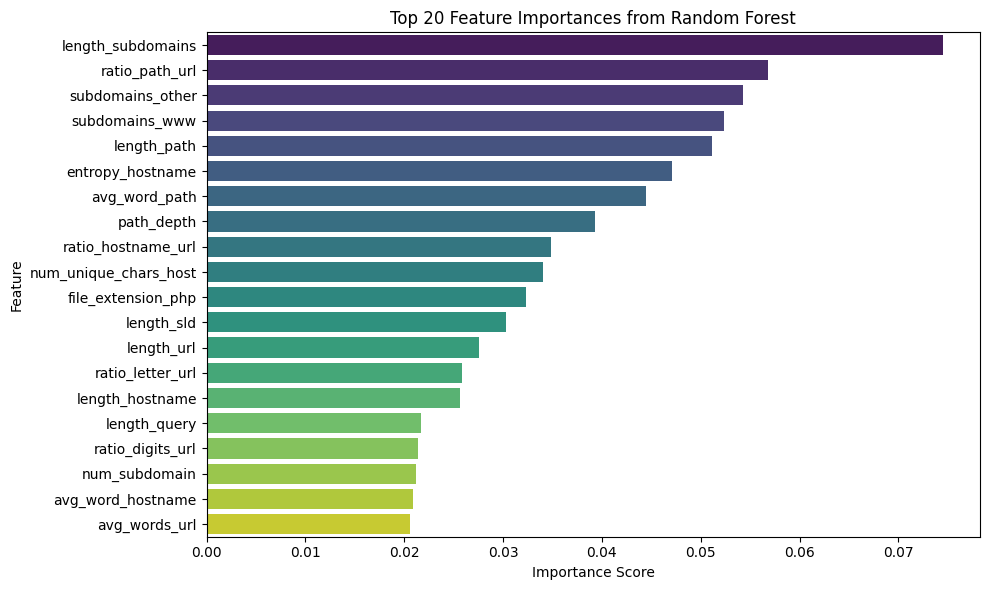

In [32]:
# plot feature importance
import matplotlib.pyplot as plt
import seaborn as sns   
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
top_20_features = feature_importances.nlargest(20)  
plt.figure(figsize=(10, 6))
sns.barplot(x=top_20_features.values, y=top_20_features.index, palette='viridis')
plt.title('Top 20 Feature Importances from Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [44]:
df_phil_train = pd.read_csv('dataset/PhiUSIIL_Phishing_URL_Dataset.csv')
df_phil_train.rename({'URL': 'url', 'label': 'target'}, axis=1, inplace=True)
df_phil_train = df_phil_train[['url', 'target']]
df_phil_train_decomposed = decompose_url(df_phil_train)

In [ ]:
df_phil_train_decomposed

,url,protocol,hostname,port,path,query,fragment,subdomains,sld,tld,filename,file_extension,directory_path,query_params,target
0,https://www.southbankmosaics.com,https,www.southbankmosaics.com,NaN,None,None,None,www,southbankmosaics,com,None,None,None,None,1
1,https://www.uni-mainz.de,https,www.uni-mainz.de,NaN,None,None,None,www,uni-mainz,de,None,None,None,None,1
2,https://www.voicefmradio.co.uk,https,www.voicefmradio.co.uk,NaN,None,None,None,www,voicefmradio,co.uk,None,None,None,None,1
3,https://www.sfnmjournal.com,https,www.sfnmjournal.com,NaN,None,None,None,www,sfnmjournal,com,None,None,None,None,1
4,https://www.rewildingargentina.org,https,www.rewildingargentina.org,NaN,None,None,None,www,rewildingargentina,org,None,None,None,None,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235790,https://www.skincareliving.com,https,www.skincareliving.com,NaN,None,None,None,www,skincareliving,com,None,None,None,None,1
235791,https://www.winchester.gov.uk,https,www.winchester.gov.uk,NaN,None,None,None,www,winchester,gov.uk,None,None,None,None,1
235792,https://www.nononsensedesign.be,https,www.nononsensedesign.be,NaN,None,None,None,www,nononsensedesign,be,None,None,None,None,1
235793,https://patient-cell-40f5.updatedlogmylogin.wo...,https,patient-cell-40f5.updatedlogmylogin.workers.dev,NaN,/,None,None,patient-cell-40f5.updatedlogmylogin,workers,dev,None,None,None,None,0


In [57]:
df_phil_train_decomposed.isna().sum()

url                    0
protocol               0
hostname               0
port              235769
path              175368
query             229716
fragment          234963
subdomains         15682
sld                    0
tld                  608
filename          208344
file_extension    223993
directory_path    219690
query_params      229716
target                 0
dtype: int64

In [48]:
df_phil_train_decomposed['path'].value_counts()

path
/                                                                           32971
/ai/                                                                          358
/jp.php                                                                       343
/v3/signin/identifier                                                         280
/vnafvra97w/                                                                  238
                                                                            ...  
/demergtlz11nasvk9lujzhfym1xwt8hgp6jzfcm97g2ceyrxuvaffse/login/                 1
/cmc111/cdo-nwst1.html                                                          1
/chpost/chpost/n/                                                               1
/icons/info.php                                                                 1
/wp-admin/dev/a32q0s%202/a32q0s/post/internet/group/04899/sslauthui.html        1
Name: count, Length: 17260, dtype: int64

In [59]:
df_processed

,url,target
0,http://www.crestonwood.com/router.php,0
1,http://shadetreetechnology.com/V4/validation/a...,1
2,https://support-appleld.com.secureupdate.duila...,1
3,http://rgipt.ac.in,0
4,http://www.iracing.com/tracks/gateway-motorspo...,0
...,...,...
11425,http://www.fontspace.com/category/blackletter,0
11426,http://www.budgetbots.com/server.php/Server%20...,1
11427,https://www.facebook.com/Interactive-Televisio...,0
11428,http://www.mypublicdomainpictures.com/,0


In [51]:
def decompose_single_url_v2(url):
    parsed = urlparse(url)
    hostname = parsed.hostname or None
    ext = tldextract.extract(hostname) if hostname else None
    
    # path decomposition
    path_parts = [p for p in parsed.path.split('/') if p] if parsed.path else []
    filename = path_parts[-1] if path_parts else None
    file_extension = filename.split('.')[-1] if filename and '.' in filename else None
    directory_path = '/'.join(path_parts[:-1]) if len(path_parts) > 1 else None
    
    # query parameters
    query_params = parsed.query.split('&') if parsed.query else None
    
    return {
        'url': url,
        'protocol': parsed.scheme or None,
        'hostname': hostname,
        # 'port': parsed.port if parsed.port is not None else None,
        # 'path': parsed.path or None,
        # 'query': parsed.query or None,
        # 'fragment': parsed.fragment or None,
        'subdomains': ext.subdomain if ext else None,
        'sld': ext.domain if ext else None,
        'tld': ext.suffix if ext else None,
        # 'filename': filename,
        # 'file_extension': file_extension,
        # 'directory_path': directory_path,
        # 'query_params': query_params
    }

In [ ]:
def decompose_url_v2(df):
    df_decomposed = df['url'].apply(lambda x: pd.Series(decompose_single_url_v2(x)))
    df_decomposed = pd.concat([df_decomposed, df['target']], axis=1)
    # convert all empty strings to None
    df_decomposed.replace('', None, inplace=True)
    # transform url
    def reconstruct_base_url(row):
        if not row['hostname']:
            return row['url']  # return original if parsing failed
        protocol = row['protocol'] if row['protocol'] else 'http'
        return f"{protocol}://{row['hostname']}"
    df_decomposed['url'] = df_decomposed.apply(reconstruct_base_url, axis=1)
    return df_decomposed

In [67]:
df_phil_train = pd.read_csv('dataset/PhiUSIIL_Phishing_URL_Dataset.csv')
df_phil_train.rename({'URL': 'url', 'label': 'target'}, axis=1, inplace=True)
df_phil_train = df_phil_train[['url', 'target']]
df_phil_train_decomposed = decompose_url_v2(df_phil_train)

In [70]:
df_phil_train_decomposed

,url,protocol,hostname,subdomains,sld,tld,target
0,https://www.southbankmosaics.com,https,www.southbankmosaics.com,www,southbankmosaics,com,1
1,https://www.uni-mainz.de,https,www.uni-mainz.de,www,uni-mainz,de,1
2,https://www.voicefmradio.co.uk,https,www.voicefmradio.co.uk,www,voicefmradio,co.uk,1
3,https://www.sfnmjournal.com,https,www.sfnmjournal.com,www,sfnmjournal,com,1
4,https://www.rewildingargentina.org,https,www.rewildingargentina.org,www,rewildingargentina,org,1
...,...,...,...,...,...,...,...
235790,https://www.skincareliving.com,https,www.skincareliving.com,www,skincareliving,com,1
235791,https://www.winchester.gov.uk,https,www.winchester.gov.uk,www,winchester,gov.uk,1
235792,https://www.nononsensedesign.be,https,www.nononsensedesign.be,www,nononsensedesign,be,1
235793,https://patient-cell-40f5.updatedlogmylogin.wo...,https,patient-cell-40f5.updatedlogmylogin.workers.dev,patient-cell-40f5.updatedlogmylogin,workers,dev,0


In [74]:
def extract_url_features_v2(df):

    final_df = df.copy()

    ## PROTOCOL FEATURES
    final_df['is_https'] = (final_df['protocol'] == 'https').astype(int)
    final_df['is_http'] = (final_df['protocol'] == 'http').astype(int)

    ## DOMAIN FEATURES
    final_df['has_subdomain'] = final_df['subdomains'].notna().astype(int)
    final_df['has_tld'] = final_df['tld'].notna().astype(int)
    final_df['num_subdomain'] = final_df['subdomains'].apply(lambda x: len(x.split('.')) if x else 0)
    # check if is IP address
    def is_ip_address(hostname):
        try:
            ipaddress.ip_address(hostname)
            return 1  
        except:
            return 0
    final_df['is_domain_ip'] = final_df['hostname'].apply(is_ip_address)
    # suspicious punctuation in domain
    final_df['num_hyphens_domain'] = final_df['hostname'].str.count('-')
    final_df['num_dots_domain'] = final_df['hostname'].str.count(r'\.')
    # detect punycode
    final_df['is_punycode'] = final_df['hostname'].str.contains('xn--', regex=False, na=False).astype(int)
    
    # ## PORT FEATURES
    # final_df['has_port'] = final_df['port'].notna().astype(int)

    # ## PATH FEATURES
    # final_df['has_path'] = final_df['path'].apply(lambda x: 1 if x and x != '/' else 0)
    # final_df['path_depth'] = final_df['path'].apply(lambda x: len([p for p in x.split('/') if p]) if x else 0)
    # final_df['has_directory_path'] = final_df['directory_path'].apply(lambda x: 1 if x and x != '/' else 0)

    # ## FILE FEATURES
    # final_df['has_filename'] = final_df['filename'].notna().astype(int)
    # final_df['has_file_extension'] = final_df['file_extension'].notna().astype(int)

    # ## QUERY FEATURES
    # final_df['has_query'] = final_df['query'].notna().astype(int) 
    # final_df['num_query_params'] = final_df['query_params'].apply(lambda x: len([p for p in x if p]) if x else 0)
    
    # ## FRAGMENT FEATURES
    # final_df['has_fragment'] = final_df['fragment'].notna().astype(int)

    ## LENGTH FEATURES
    final_df['length_url'] = final_df['url'].str.len()
    final_df['length_hostname'] = final_df['hostname'].str.len()
    final_df['length_tld'] = final_df['tld'].str.len()
    final_df['length_sld'] = final_df['sld'].str.len()
    final_df['length_subdomains'] = final_df['subdomains'].str.len()
    # final_df['length_path'] = final_df['path'].str.len()
    # final_df['length_query'] = final_df['query'].str.len()
    # final_df['length_fragment'] = final_df['fragment'].str.len()

    ## PUNCTUATION FEATURES
    final_df['num_dots'] = final_df['url'].str.count(r'\.')
    final_df['num_hyphens'] = final_df['url'].str.count('-')
    final_df['num_at'] = final_df['url'].str.count('@')
    final_df['num_question_marks'] = final_df['url'].str.count(r'\?')
    final_df['num_and'] = final_df['url'].str.count('&')
    final_df['num_equal'] = final_df['url'].str.count('=')
    final_df['num_underscores'] = final_df['url'].str.count('_')    
    final_df['num_slashes'] = final_df['url'].str.count('/')
    final_df['num_percent'] = final_df['url'].str.count('%')
    final_df['num_dollars'] = final_df['url'].str.count(r'\$')
    final_df['num_colon'] = final_df['url'].str.count(':')
    final_df['num_semicolon'] = final_df['url'].str.count(';')
    final_df['num_comma'] = final_df['url'].str.count(',')
    final_df['num_hashtag'] = final_df['url'].str.count('#')
    final_df['num_tilde'] = final_df['url'].str.count('~')

    ## SUSPICIOUS PATTERNS FEATURES
    # final_df['http_in_path'] = final_df['path'].str.lower().str.contains('http', regex=False, na=False).astype(int)
    # final_df['tld_in_path'] = final_df['path'].apply(lambda x: 1 if x and any(ext in x.lower() for ext in ['.com', '.net', '.org']) else 0)
    final_df['tld_in_subdomain'] = final_df['subdomains'].apply(lambda x: 1 if x and any(ext in x for ext in ['.com', '.net', '.org']) else 0)
    final_df['subdomain_longer_sld'] = (final_df['length_subdomains'] > final_df['length_sld']).astype(int)
    # final_df['double_slash_in_path'] = final_df['path'].str.contains('//', na=False).astype(int)

    ## RATIO FEATURES
    final_df['ratio_digits_url'] = final_df['url'].apply(lambda x: sum(c.isdigit() for c in x) / len(x) if len(x) > 0 else 0)
    final_df['ratio_digits_hostname'] = final_df['hostname'].apply(lambda x: sum(c.isdigit() for c in x) / len(x) if len(x) > 0 else 0)
    final_df['ratio_letter_url'] = final_df['url'].apply(lambda x: sum(c.isalpha() for c in x) / len(x) if len(x) > 0 else 0)
    final_df['ratio_special_char_url'] = final_df['url'].apply(lambda x: sum(not c.isalnum() and c not in ['/', ':', '.'] for c in x) / len(x) if len(x) > 0 else 0)
    # proportion of components
    # final_df['ratio_path_url'] = final_df['length_path'] / final_df['length_url']
    final_df['ratio_hostname_url'] = final_df['length_hostname'] / final_df['length_url']
    
    # WORD-BASED FEATURES 
    words_raw = final_df['url'].apply(lambda x: re.findall(r'\w+', x) if x else [])
    words_host = final_df['hostname'].apply(lambda x: re.findall(r'\w+', x) if x else [])
    # words_path = final_df['path'].apply(lambda x: re.findall(r'\w+', x) if x else [])
    final_df['length_words_url'] = words_raw.apply(len)
    final_df['avg_words_url'] = words_raw.apply(lambda x: np.mean([len(w) for w in x]) if x else 0)
    final_df['avg_word_hostname'] = words_host.apply(lambda x: np.mean([len(w) for w in x]) if x else 0)
    # final_df['avg_word_path'] = words_path.apply(lambda x: np.mean([len(w) for w in x]) if x else 0)

    ## CHARACTER BASED FEATURES
    final_df['num_unique_chars_host'] = final_df['hostname'].apply(lambda x: len(set(x)) if x else 0)
    final_df['num_non_ascii_url'] = final_df['url'].apply(lambda x: sum(1 for c in x if ord(c) > 127) if x else 0)
    final_df['longest_repeated_char_url'] = final_df['url'].apply(lambda x: max([len(list(g)) for k, g in re.findall(r'((.)\2*)', x)]) if x else 0)
    final_df['longest_repeated_char_host'] = final_df['hostname'].apply(lambda x: max([len(list(g)) for k, g in re.findall(r'((.)\2*)', x)]) if x else 0)

    # URL SHORTENING FEATURES
    shortening_services = ['bit.ly', 'goo.gl', 'tinyurl', 't.co', 'ow.ly', 'is.gd', 'buff.ly']
    final_df['has_shortened_hostname'] = final_df['hostname'].str.lower().apply(lambda x: 1 if any(service in x for service in shortening_services) else 0)
    
    # ENTROPY FEATURES
    def calculate_entropy(domain):
        if not domain or len(domain) == 0:
            return 0
        domain_clean = re.sub(r'[^a-z]', '', domain.lower())
        if len(domain_clean) == 0:
            return 0
        char_freq = Counter(domain_clean)
        entropy = -sum((count/len(domain_clean)) * np.log2(count/len(domain_clean)) 
                      for count in char_freq.values())
        return entropy
    final_df['entropy_hostname'] = final_df['hostname'].apply(calculate_entropy)

    
    return final_df

In [ ]:
df_feature_engineered = extract_url_features_v2(df_phil_train_decomposed)

In [78]:
# fit random forest again
rf = RandomForestClassifier(n_estimators=100, random_state=42)
X = df_feature_engineered.drop(columns=['url', 'protocol', 'hostname', 'subdomains', 'sld', 'tld', 'target'])
y = df_feature_engineered['target']
rf.fit(X, y)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [102]:
df_test = pd.read_csv('dataset/kaggle_phishing_dataset.csv')
df_test = preprocess(df_test)

In [103]:
df_test = decompose_url_v2(df_test)
df_test_features = extract_url_features_v2(df_test)

In [107]:
df_test_features

,url,protocol,hostname,subdomains,sld,tld,target,is_https,is_http,has_subdomain,has_tld,num_subdomain,is_domain_ip,num_hyphens_domain,num_dots_domain,is_punycode,length_url,length_hostname,length_tld,length_sld,length_subdomains,num_dots,num_hyphens,num_at,num_question_marks,num_and,num_equal,num_underscores,num_slashes,num_percent,num_dollars,num_colon,num_semicolon,num_comma,num_hashtag,num_tilde,tld_in_subdomain,subdomain_longer_sld,ratio_digits_url,ratio_digits_hostname,ratio_letter_url,ratio_special_char_url,ratio_hostname_url,length_words_url,avg_words_url,avg_word_hostname,num_unique_chars_host,num_non_ascii_url,longest_repeated_char_url,longest_repeated_char_host,has_shortened_hostname,entropy_hostname
0,http://www.crestonwood.com,http,www.crestonwood.com,www,crestonwood,com,0,0,1,1,1,1,0,0,2,0,26,19,3.0,11,3.0,2,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0.00000,0.000000,0.807692,0.000000,0.730769,4,5.250000,5.666667,11,0,1,1,0,3.028639
1,http://shadetreetechnology.com,http,shadetreetechnology.com,None,shadetreetechnology,com,1,0,1,0,1,0,0,0,1,0,30,23,3.0,19,NaN,1,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0.00000,0.000000,0.866667,0.000000,0.766667,3,8.666667,11.000000,15,0,1,1,0,3.606937
2,https://support-appleld.com.secureupdate.duila...,https,support-appleld.com.secureupdate.duilawyeryork...,support-appleld.com.secureupdate,duilawyeryork,com,1,1,0,1,1,3,0,1,4,0,58,50,3.0,13,32.0,4,1,0,0,0,0,0,2,0,0,1,0,0,0,0,1,1,0.00000,0.000000,0.862069,0.017241,0.862069,7,7.142857,7.500000,18,0,1,1,0,3.842101
3,http://rgipt.ac.in,http,rgipt.ac.in,None,rgipt,ac.in,0,0,1,0,1,0,0,0,2,0,18,11,5.0,5,NaN,2,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0.00000,0.000000,0.722222,0.000000,0.611111,4,3.250000,3.000000,9,0,1,1,0,2.947703
4,http://www.iracing.com,http,www.iracing.com,www,iracing,com,0,0,1,1,1,1,0,0,2,0,22,15,3.0,7,3.0,2,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0.00000,0.000000,0.772727,0.000000,0.681818,4,4.250000,4.333333,10,0,1,1,0,3.026987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11425,http://www.fontspace.com,http,www.fontspace.com,www,fontspace,com,0,0,1,1,1,1,0,0,2,0,24,17,3.0,9,3.0,2,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0.00000,0.000000,0.791667,0.000000,0.708333,4,4.750000,5.000000,12,0,1,1,0,3.323231
11426,http://www.budgetbots.com,http,www.budgetbots.com,www,budgetbots,com,1,0,1,1,1,1,0,0,2,0,25,18,3.0,10,3.0,2,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0.00000,0.000000,0.800000,0.000000,0.720000,4,5.000000,5.333333,12,0,1,1,0,3.327820
11427,https://www.facebook.com,https,www.facebook.com,www,facebook,com,0,1,0,1,1,1,0,0,2,0,24,16,3.0,8,3.0,2,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0.00000,0.000000,0.791667,0.000000,0.666667,4,4.750000,4.666667,10,0,1,1,0,2.985228
11428,http://www.mypublicdomainpictures.com,http,www.mypublicdomainpictures.com,www,mypublicdomainpictures,com,0,0,1,1,1,1,0,0,2,0,37,30,3.0,22,3.0,2,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0.00000,0.000000,0.864865,0.000000,0.810811,4,8.000000,9.333333,18,0,1,1,0,3.913800


In [105]:
# run model for prediction and output rocauc
X_test_final = df_test_features.drop(columns=['url', 'protocol', 'hostname', 'subdomains', 'sld', 'tld', 'target'])
y_test_final = df_test_features['target']
y_proba_final = rf.predict_proba(X_test_final)[:, 1]
roc_auc_final = roc_auc_score(y_test_final, y_proba_final)
print(f'Final ROC AUC on Kaggle dataset: {roc_auc_final:.4f}')

Final ROC AUC on Kaggle dataset: 0.3739


In [113]:
#try combine both dataset, do test train split stratigfy then train on one and test on the other
df_kaggle = pd.read_csv('dataset/kaggle_phishing_dataset.csv')
df_kaggle = preprocess(df_kaggle)   
df_kaggle_decomposed = decompose_url_v2(df_kaggle)

df_combined = pd.concat([df_phil_train_decomposed, df_kaggle_decomposed], ignore_index=True)
df_combined_features = extract_url_features_v2(df_combined)

X_combined = df_combined_features.drop(columns=['url', 'protocol', 'hostname', 'subdomains', 'sld', 'tld', 'target'])
y_combined = df_combined_features['target']
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42, stratify=y_combined)

rf_combined = RandomForestClassifier(n_estimators=100, random_state=42)
rf_combined.fit(X_train_combined, y_train_combined)
y_proba_combined = rf_combined.predict_proba(X_test_combined)[:, 1]
roc_auc_combined = roc_auc_score(y_test_combined, y_proba_combined)
print(f'Combined Dataset ROC AUC: {roc_auc_combined:.4f}')  

Combined Dataset ROC AUC: 0.9808


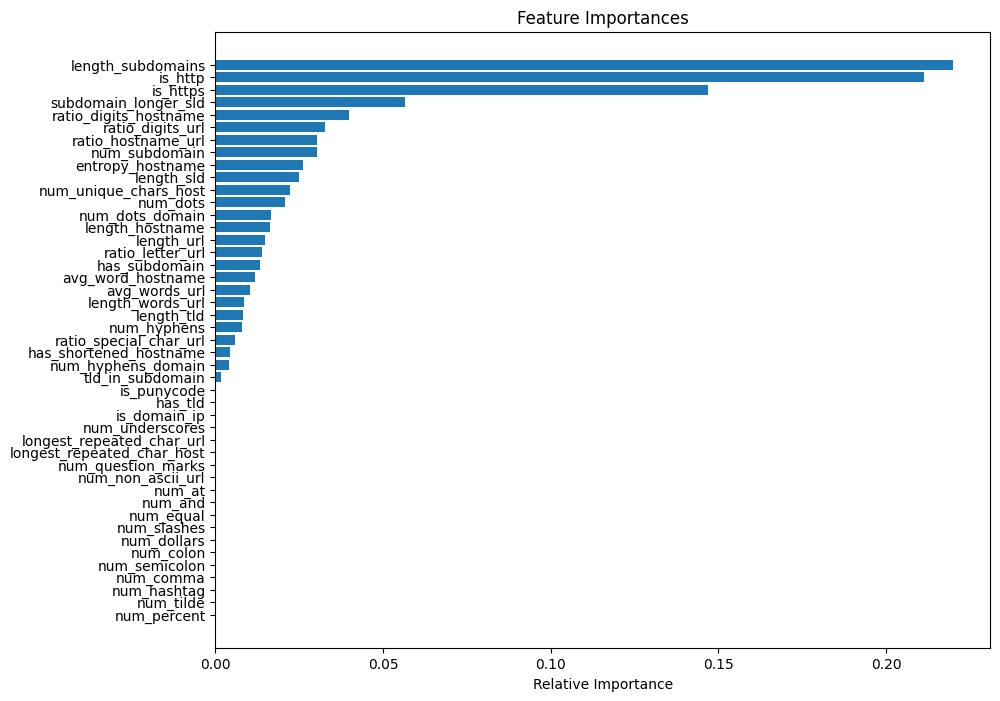

In [115]:
# plot feature importance horizontal bar chart
import matplotlib.pyplot as plt
feature_importances = rf_combined.feature_importances_
features = X_train_combined.columns
indices = np.argsort(feature_importances)   
plt.figure(figsize=(10, 8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices]) 
plt.xlabel('Relative Importance')
plt.show()  


In [117]:
df_kaggle_features = extract_url_features_v2(df_kaggle_decomposed)

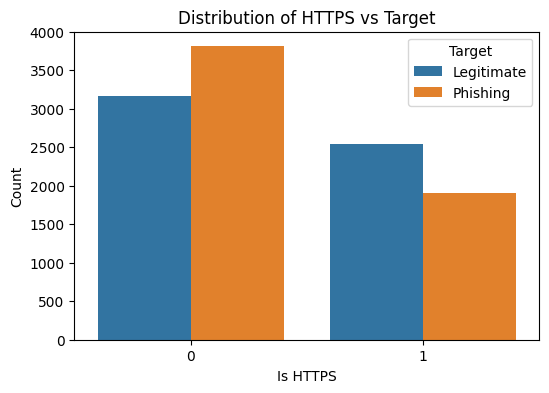

In [121]:
# plot feature of ishttps vs target
import seaborn as sns
plt.figure(figsize=(6,4))
sns.countplot(x='is_https', hue='target', data=df_kaggle_features)
plt.title('Distribution of HTTPS vs Target')
plt.xlabel('Is HTTPS')
plt.ylabel('Count')
plt.legend(title='Target', labels=['Legitimate', 'Phishing'])
plt.show()

In [123]:
df_phil_train_features = extract_url_features_v2(df_phil_train_decomposed)

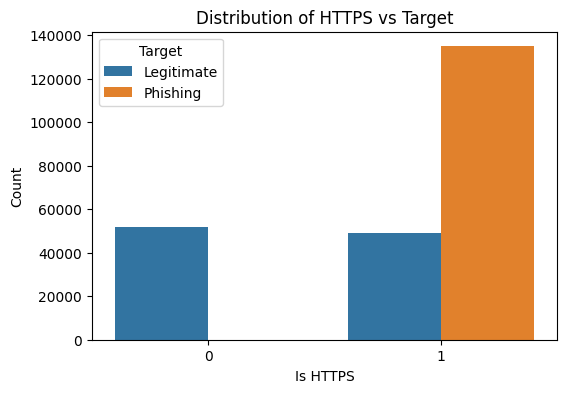

In [126]:
# plot feature of ishttps vs target
import seaborn as sns
plt.figure(figsize=(6,4))
sns.countplot(x='is_https', hue='target', data=df_phil_train_features)
plt.title('Distribution of HTTPS vs Target')
plt.xlabel('Is HTTPS')
plt.ylabel('Count')
plt.legend(title='Target', labels=['Legitimate', 'Phishing'])
plt.show()

In [112]:
df_phil_train_decomposed

,url,protocol,hostname,subdomains,sld,tld,target
0,https://www.southbankmosaics.com,https,www.southbankmosaics.com,www,southbankmosaics,com,1
1,https://www.uni-mainz.de,https,www.uni-mainz.de,www,uni-mainz,de,1
2,https://www.voicefmradio.co.uk,https,www.voicefmradio.co.uk,www,voicefmradio,co.uk,1
3,https://www.sfnmjournal.com,https,www.sfnmjournal.com,www,sfnmjournal,com,1
4,https://www.rewildingargentina.org,https,www.rewildingargentina.org,www,rewildingargentina,org,1
...,...,...,...,...,...,...,...
235790,https://www.skincareliving.com,https,www.skincareliving.com,www,skincareliving,com,1
235791,https://www.winchester.gov.uk,https,www.winchester.gov.uk,www,winchester,gov.uk,1
235792,https://www.nononsensedesign.be,https,www.nononsensedesign.be,www,nononsensedesign,be,1
235793,https://patient-cell-40f5.updatedlogmylogin.wo...,https,patient-cell-40f5.updatedlogmylogin.workers.dev,patient-cell-40f5.updatedlogmylogin,workers,dev,0


In [111]:
df_kaggle_decomposed

,url,protocol,hostname,subdomains,sld,tld,target
0,http://www.crestonwood.com,http,www.crestonwood.com,www,crestonwood,com,0
1,http://shadetreetechnology.com,http,shadetreetechnology.com,None,shadetreetechnology,com,1
2,https://support-appleld.com.secureupdate.duila...,https,support-appleld.com.secureupdate.duilawyeryork...,support-appleld.com.secureupdate,duilawyeryork,com,1
3,http://rgipt.ac.in,http,rgipt.ac.in,None,rgipt,ac.in,0
4,http://www.iracing.com,http,www.iracing.com,www,iracing,com,0
...,...,...,...,...,...,...,...
11425,http://www.fontspace.com,http,www.fontspace.com,www,fontspace,com,0
11426,http://www.budgetbots.com,http,www.budgetbots.com,www,budgetbots,com,1
11427,https://www.facebook.com,https,www.facebook.com,www,facebook,com,0
11428,http://www.mypublicdomainpictures.com,http,www.mypublicdomainpictures.com,www,mypublicdomainpictures,com,0


In [ ]:
df_kaggle_decomposed['']

In [134]:
# try test train split with kaggle data only
from xgboost import XGBClassifier
X_kaggle = df_kaggle_features.drop(columns=['url', 'protocol', 'hostname', 'sld', 'target'])
y_kaggle = df_kaggle_features['target']
X_train_kaggle, X_test_kaggle, y_train_kaggle, y_test_kaggle = train_test_split(X_kaggle, y_kaggle, test_size=0.2, random_state=42, stratify=y_kaggle)

# for the subdomains, tld, get the top 5 and set rest to other, then one hot encode
for col in ['subdomains', 'tld']:
    top_5 = df_kaggle_decomposed[col].value_counts().nlargest(5).index
    X_train_kaggle[col] = X_train_kaggle[col].apply(lambda x: x if x in top_5 else 'other')
    X_test_kaggle[col] = X_test_kaggle[col].apply(lambda x: x if x in top_5 else 'other')
    X_train_kaggle = pd.get_dummies(X_train_kaggle, columns=[col], prefix=col)
    X_test_kaggle = pd.get_dummies(X_test_kaggle, columns=[col], prefix=col)

rf_kaggle = XGBClassifier(n_estimators=200, random_state=42)
rf_kaggle.fit(X_train_kaggle, y_train_kaggle)
y_proba_kaggle = rf_kaggle.predict_proba(X_test_kaggle)[:, 1]
roc_auc_kaggle = roc_auc_score(y_test_kaggle, y_proba_kaggle)
print(f'Kaggle Dataset ROC AUC: {roc_auc_kaggle:.4f}')

Kaggle Dataset ROC AUC: 0.8934


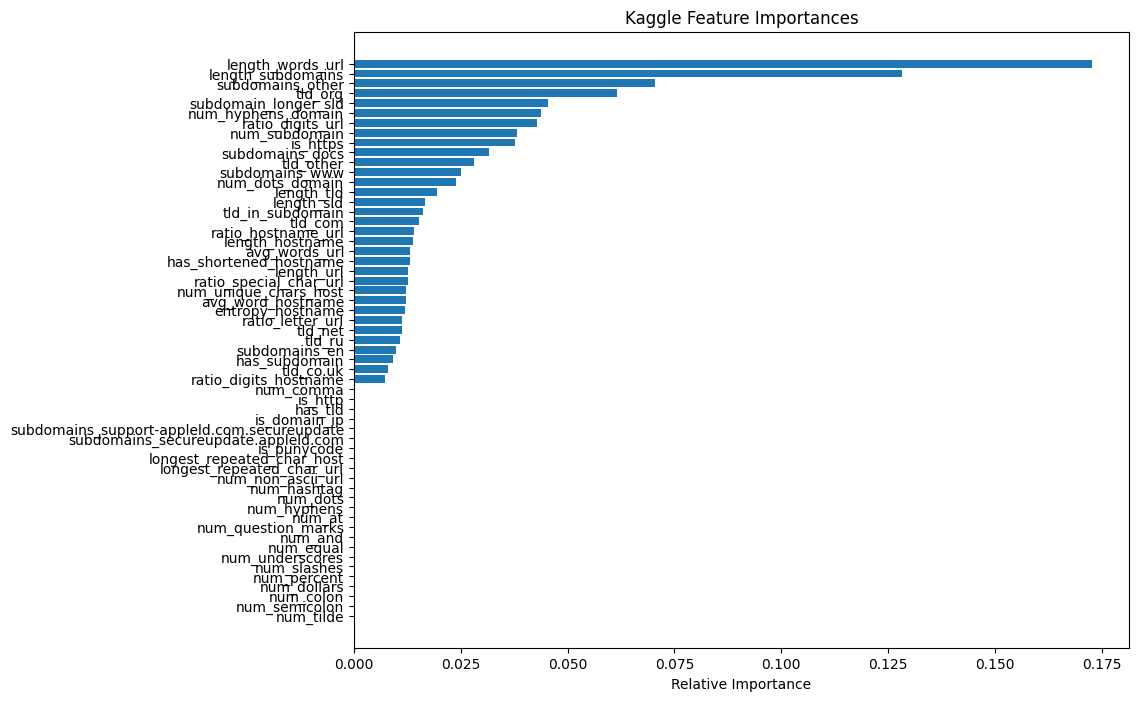

In [135]:
# feature importance plot
feature_importances_kaggle = rf_kaggle.feature_importances_
features_kaggle = X_train_kaggle.columns
indices_kaggle = np.argsort(feature_importances_kaggle)
plt.figure(figsize=(10, 8))
plt.title('Kaggle Feature Importances')
plt.barh(range(len(indices_kaggle)), feature_importances_kaggle[indices_kaggle], align='center')
plt.yticks(range(len(indices_kaggle)), [features_kaggle[i] for i in indices_kaggle]) 
plt.xlabel('Relative Importance')
plt.show()  

In [ ]:
# subplot of all